#### Gerekli Kütüphaneler

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from typing import Optional
    
from lightgbm import LGBMRegressor
from lightgbm import plot_importance

from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer

from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans

- Pandas ayarlar

In [2]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

#### Veri setlerini yükleme

In [3]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample_submission = pd.read_csv("sample_submission.csv")

#### Veriyi inceleme

In [4]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
train.describe().T

- Fonksiyon tanımlamaları

In [ ]:
# Verisetinin değişkenlerini tespit etme                                                                                     
def grab_col_names(df, cat_th=10, car_th=20):

    # Categorical Columns
    cat_cols = [col for col in df.columns if df[col].dtypes == "O"]
    num_but_cat = [col for col in df.columns if df[col].nunique() < cat_th and df[col].dtypes != "O"]
    cat_but_car = [col for col in df.columns if df[col].nunique() > car_th and df[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # Numerical Columns
    num_cols = [col for col in df.columns if df[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    # Results
    print(f"Observations: {df.shape[0]}")
    print(f"Variables: {df.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, cat_but_car, num_cols    

In [ ]:
train.Alley.count()

In [49]:
# Kategorik değişken analizi                              
def categorical_value_counts(df, col, target: None, rare: Optional[float] = None):
    temp = df.groupby(col, dropna=False).agg(Count=(col, lambda x: x.isnull().count()), \
                               Ratio=(col, lambda x: x.isnull().count() / len(df)), \
                               Target_Ratio=(target, lambda x: x.sum() / df[target].sum())) \
        .sort_values("Count", ascending=False).reset_index()

    if rare is not None:
        rares = temp.loc[temp["Ratio"] <= float(rare), col].tolist()
        df.loc[df[col].isin(rares), col] = "Rare Category"
        print("---- Done! --- ")
        print(df.groupby(col).agg(Count=(col, lambda x: x.count()), \
                                  Ratio=(col, lambda x: x.count() / len(df)), \
                                  Target_Ratio=(target, lambda x: x.sum() / df[target].sum())) \
              .sort_values("Count", ascending=False).reset_index(), "\n")
    else:
        print(temp, "\n")

In [51]:
categorical_value_counts(train, "LotShape", "SalePrice")

  LotShape  Count     Ratio  Target_Ratio
0      Reg    925  0.633562      0.576949
1      IR1    484  0.331507      0.377646
2      IR2     41  0.028082      0.037226
3      IR3     10  0.006849      0.008179 



In [ ]:
def outliers(df, col, low_Quantile = 0.25, high_Quantile = 0.75, adjust = False):  
    Q1 = df[col].quantile(low_Quantile)
    Q3 = df[col].quantile(high_Quantile)
    IQR = Q3 - Q1
    low_Limit = Q1 - (1.5 * IQR)
    up_Limit = Q3 + (1.5 * IQR)
    
    if len(df[df[col] > up_Limit]) > 0:
        print(col, ": Higher Outlier!")
    if len(df[df[col] < low_Limit]) > 0:
        print(col, ": Lower Outlier!")
        
    if adjust:
        df.loc[(df[col] < low_Limit), col] = low_Limit
        df.loc[(df[col] > up_Limit), col] = up_Limit
        print(col, ": Done!")

In [ ]:
cat_cols, cat_but_car, num_cols = grab_col_names(train)

In [ ]:
for col in cat_cols:
    categorical_value_counts(train, col, "SalePrice")

In [25]:
RS = RobustScaler()

In [ ]:
RS = RobustScaler()

train["MSSubClass"] = RS.fit_transform(train[["MSSubClass"]])
train["LotFrontage"] = RS.fit_transform(train[["LotFrontage"]])
train["LotFrontage"] = train["LotFrontage"].fillna(train["LotFrontage"].mean())
train["New_OverallQual"] = pd.cut(train["OverallQual"], bins=[-1, 5, 8, 11], labels=[0, 1, 2])
train["New_OverallCond"] = pd.cut(train["OverallCond"], bins=[0, 5, 8, 10], labels=[0, 1, 2])
train["New_YearBuilt"] = pd.cut(train["YearBuilt"], bins=[1871, 1943, 1990, 2011], labels=[0, 1, 2])
train["New_YearRemodAdd"] = pd.cut(train["YearRemodAdd"], bins=[1949, 1990, 2011], labels=[0, 1])
train["MasVnrType"] = train["MasVnrType"].fillna("None")
train["MasVnrArea"] = train["MasVnrArea"].fillna(0)
train["MasVnrArea"] = RS.fit_transform(train[["MasVnrArea"]])
train["BsmtFinSF1"] = RS.fit_transform(train[["BsmtFinSF1"]])
train["BsmtFinSF2"] = RS.fit_transform(train[["BsmtFinSF2"]])
train["BsmtUnfSF"] = RS.fit_transform(train[["BsmtUnfSF"]])
train["2ndFlrSF"] = train["2ndFlrSF"].apply(lambda x: 0 if x == 0 else 1) 
train["LowQualFinSF"] = train["LowQualFinSF"].apply(lambda x: 0 if x == 0 else 1) 

train["LotArea"] = RS.fit_transform(train[["LotArea"]])
train["Alley"] = train["Alley"].fillna("Unknown")
train["BsmtQual"] = train["BsmtQual"].fillna("Unknown")
train["BsmtCond"] = train["BsmtCond"].fillna("TA")
train["BsmtExposure"] = train["BsmtExposure"].fillna("Unknown")
train["BsmtFinType1"] = train["BsmtFinType1"].fillna("Unknown")
train["BsmtFinType2"] = train["BsmtFinType2"].fillna("Unf")
train["Electrical"] = train["Electrical"].fillna("SBrkr")
train["FireplaceQu"] = train["FireplaceQu"].fillna("Unknown")
train["GarageType"] = train["GarageType"].fillna("None")
train["GarageYrBlt"] = train["GarageYrBlt"].fillna("0")
train["GarageFinish"] = train["GarageFinish"].fillna("None")
train["GarageQual"] = train["GarageQual"].fillna("None")
train["GarageCond"] = train["GarageCond"].fillna("None")
train["PoolQC"] = train["PoolQC"].fillna("None")
train["Fence"] = train["Fence"].fillna("Unknown")
train["MiscFeature"] = train["MiscFeature"].fillna("None")

In [ ]:
categorical_value_counts(train, "MSZoning", "SalePrice", 0.05)
# Street
categorical_value_counts(train, "Alley", "SalePrice", 0.05)
categorical_value_counts(train, "LotShape", "SalePrice", 0.05)
categorical_value_counts(train, "LandContour", "SalePrice", 0.05)
#Utilities
categorical_value_counts(train, "LotConfig", "SalePrice", 0.05) # 0.07
categorical_value_counts(train, "LandSlope", "SalePrice", 0.05)
categorical_value_counts(train, "Condition1", "SalePrice", 0.06)
categorical_value_counts(train, "Condition2", "SalePrice", 0.05)
categorical_value_counts(train, "BldgType", "SalePrice", 0.07) # 0.09
categorical_value_counts(train, "HouseStyle", "SalePrice", 0.05)
categorical_value_counts(train, "RoofStyle", "SalePrice", 0.05)
categorical_value_counts(train, "RoofMatl", "SalePrice", 0.05)
categorical_value_counts(train, "Exterior1st", "SalePrice", 0.05)
categorical_value_counts(train, "Exterior2nd", "SalePrice", 0.05)
#MasVnrType
categorical_value_counts(train, "ExterQual", "SalePrice", 0.05)
categorical_value_counts(train, "ExterCond", "SalePrice", 0.05)
categorical_value_counts(train, "Foundation", "SalePrice", 0.05)
categorical_value_counts(train, "BsmtQual", "SalePrice", 0.05)
categorical_value_counts(train, "BsmtCond", "SalePrice", 0.05)
#BsmtExposure
#BsmtFinType1
categorical_value_counts(train, "BsmtFinType2", "SalePrice", 0.05)
categorical_value_counts(train, "Heating", "SalePrice", 0.05)
categorical_value_counts(train, "HeatingQC", "SalePrice", 0.05)
#CentralAir
categorical_value_counts(train, "Electrical", "SalePrice", 0.1)
#KitchenQual
categorical_value_counts(train, "Functional", "SalePrice", 0.05)
categorical_value_counts(train, "FireplaceQu", "SalePrice", 0.05)
categorical_value_counts(train, "GarageType", "SalePrice", 0.1)
#GarageFinish
categorical_value_counts(train, "GarageQual", "SalePrice", 0.05)
categorical_value_counts(train, "GarageCond", "SalePrice", 0.05)
categorical_value_counts(train, "PavedDrive", "SalePrice", 0.1)
categorical_value_counts(train, "PoolQC", "SalePrice", 0.05)
categorical_value_counts(train, "Fence", "SalePrice", 0.05)
categorical_value_counts(train, "MiscFeature", "SalePrice", 0.05)
categorical_value_counts(train, "SaleType", "SalePrice", 0.05)
categorical_value_counts(train, "SaleCondition", "SalePrice", 0.05)
#OverallCond
categorical_value_counts(train, "BsmtFullBath", "SalePrice", 0.05)
categorical_value_counts(train, "BsmtHalfBath", "SalePrice", 0.06)
#categorical_value_counts(train, "FullBath", "SalePrice", 0.05)
#HalfBath
categorical_value_counts(train, "Alley", "SalePrice", 0.05)
#BedroomAbvGr
#KitchenAbvGr
#Fireplaces
#GarageCars
#PoolArea
#YrSold

In [ ]:
train.isnull().sum()

In [ ]:
train.info()

In [31]:
train["LotFrontage"] = train["LotFrontage"].fillna(0)

Min: 0.0
Max: 313.0
Null Count: 0
Mean: 57.62328767123287


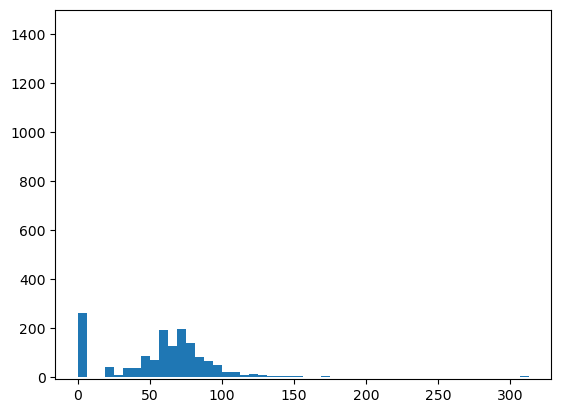

In [32]:
col = "LotFrontage"
print("Min:", train[col].min())
print("Max:", train[col].max())
print("Null Count:", train[col].isnull().sum())
print("Mean:", train[col].mean())
plt.ylim(-10, 1500)
plt.hist(train[col], bins=50);

Min: 0.0
Max: 313.0
Null Count: 0
Mean: 57.62328767123287


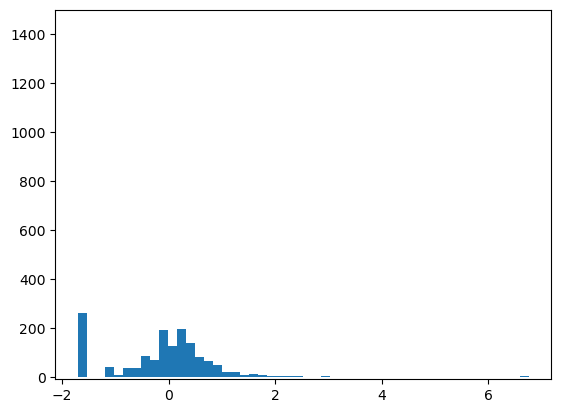

In [34]:
col = "LotFrontage"
print("Min:", train[col].min())
print("Max:", train[col].max())
print("Null Count:", train[col].isnull().sum())
print("Mean:", train[col].mean())
plt.ylim(-10, 1500)
plt.hist(RS.fit_transform(train[[col]]), bins=50);

In [38]:
temp=categorical_value_counts(train, "Alley", "SalePrice")
temp[temp["Ratio"] < 0.07]["Allley"]

  Alley  Count     Ratio  Target_Ratio
0   NaN   1369  0.000000      0.950788
1  Grvl     50  0.034247      0.023135
2  Pave     41  0.028082      0.026077 



TypeError: 'NoneType' object is not subscriptable

<function __main__.<lambda>(x)>

In [19]:
test.MSZoning.value_counts(dropna=False)

RL         1114
RM          242
FV           74
C (all)      15
RH           10
NaN           4
Name: MSZoning, dtype: int64

In [30]:
train[train["LotFrontage"].isnull()]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,Ex,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
12,13,20,RL,NaN,12968,Pave,NaN,IR2,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,1Fam,1Story,5,6,1962,1962,Hip,CompShg,HdBoard,Plywood,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,737,Unf,0,175,912,GasA,TA,Y,SBrkr,912,0,0,912,1,0,1,0,2,1,TA,4,Typ,0,NaN,Detchd,1962.0,Unf,1,352,TA,TA,Y,140,0,0,0,176,0,NaN,NaN,NaN,0,9,2008,WD,Normal,144000
14,15,20,RL,NaN,10920,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,MetalSd,MetalSd,BrkFace,212.0,TA,TA,CBlock,TA,TA,No,BLQ,733,Unf,0,520,1253,GasA,TA,Y,SBrkr,1253,0,0,1253,1,0,1,1,2,1,TA,5,Typ,1,Fa,Attchd,1960.0,RFn,1,352,TA,TA,Y,0,213,176,0,0,0,NaN,GdWo,NaN,0,5,2008,WD,Normal,157000
16,17,20,RL,NaN,11241,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,7,1970,1970,Gable,CompShg,Wd Sdng,Wd Sdng,BrkFace,180.0,TA,TA,CBlock,TA,TA,No,ALQ,578,Unf,0,426,1004,GasA,Ex,Y,SBrkr,1004,0,0,1004,1,0,1,0,2,1,TA,5,Typ,1,TA,Attchd,1970.0,Fin,2,480,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,Shed,700,3,2010,WD,Normal,149000
24,25,20,RL,NaN,8246,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,1Fam,1Story,5,8,1968,2001,Gable,CompShg,Plywood,Plywood,None,0.0,TA,Gd,CBlock,TA,TA,Mn,Rec,188,ALQ,668,204,1060,GasA,Ex,Y,SBrkr,1060,0,0,1060,1,0,1,0,3,1,Gd,6,Typ,1,TA,Attchd,1968.0,Unf,1,270,TA,TA,Y,406,90,0,0,0,0,NaN,MnPrv,NaN,0,5,2010,WD,Normal,154000
31,32,20,RL,NaN,8544,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,Norm,Norm,1Fam,1Story,5,6,1966,2006,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0,Unf,0,1228,1228,GasA,Gd,Y,SBrkr,1228,0,0,1228,0,0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1966.0,Unf,1,271,TA,TA,Y,0,65,0,0,0,0,NaN,MnPrv,NaN,0,6,2008,WD,Normal,149350
42,43,85,RL,NaN,9180,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,Norm,1Fam,SFoyer,5,7,1983,1983,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,CBlock,Gd,TA,Av,ALQ,747,LwQ,93,0,840,GasA,Gd,Y,SBrkr,884,0,0,884,1,0,1,0,2,1,Gd,5,Typ,0,NaN,Attchd,1983.0,RFn,2,504,TA,Gd,Y,240,0,0,0,0,0,NaN,MnPrv,NaN,0,12,2007,WD,Normal,144000
43,44,20,RL,NaN,9200,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,CollgCr,Norm,Norm,1Fam,1Story,5,6,1975,1980,Hip,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,Gd,TA,Av,LwQ,280,BLQ,491,167,938,GasA,TA,Y,SBrkr,938,0,0,938,1,0,1,0,3,1,TA,5,Typ,0,NaN,Detchd,1977.0,Unf,1,308,TA,TA,Y,145,0,0,0,0,0,NaN,MnPrv,NaN,0,7,2008,WD,Normal,130250
50,51,60,RL,NaN,13869,Pave,NaN,IR2,Lvl,AllPub,Corner,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1997,1997,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,Av,GLQ,182,Unf,0,612,794,GasA,Gd,Y,SBrkr,794,676,0,1470,0,1,2,0,3,1,TA,6,Typ,0,NaN,Attchd,1997.0,Fin,2,388,TA,TA,Y,0,75,0,0,0,0,NaN,NaN,NaN,0,7,2007,WD,Normal,177000
64,65,60,RL,NaN,9375,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,573.0,TA,TA,PConc,Gd,TA,No,GLQ,739,Unf,0,318,1057,GasA,Ex,Y,SB

In [5]:
train.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,Ex,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,NaN,Attchd,1993.0,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,Ex,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.0,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,Ex,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,Gd,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931.0,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,1.5Unf,5,6,1939,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,BrkTil,TA,TA,No,GLQ,851,Unf,0,140,991,Gas

In [ ]:
dummied1=pd.get_dummies(data=train, 
               columns=["MSZoning", "Street", "Alley", 
                        "LotShape", "LandContour", "Utilities", 
                        "LotConfig", "LandSlope", "Neighborhood", 
                        "Condition1", "Condition2", "BldgType", 
                        "HouseStyle", "RoofStyle", "RoofMatl", 
                        "Exterior1st", "Exterior2nd", "MasVnrType", 
                        "ExterQual", "ExterCond", "Foundation", 
                        "BsmtQual", "BsmtCond", "BsmtExposure", 
                        "BsmtFinType1", "BsmtFinType2", "Heating", 
                        "HeatingQC", "CentralAir", "Electrical", 
                        "BsmtHalfBath", "KitchenQual", "Functional", 
                        "FireplaceQu", "GarageType", "GarageFinish", 
                        "GarageQual", "GarageCond", "PavedDrive", 
                        "PoolQC", "Fence", "MiscFeature", 
                        "SaleType", "SaleCondition"],
              drop_first=True)

In [ ]:
dummied1.dtypes

In [ ]:
dummied1.shape

In [ ]:
dummied1.isnull().sum()

In [ ]:
dummied2=pd.get_dummies(data=train, drop_first=False)

In [ ]:
dummied2.shape

In [ ]:
X_train = dummied1.drop("SalePrice", axis=1)
y_train = dummied1["SalePrice"]

In [ ]:
CB_model = CatBoostRegressor(verbose=False)
CB_model.fit(X_train, y_train)
print("Train Score:", CB_model.score(X_train, y_train))
y_pred = CB_model.predict(X_train)
print("MAPE:", mean_absolute_percentage_error(y_train, y_pred))
print("MAE:", mean_absolute_error(y_train, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_train, y_pred)))

In [ ]:
LGBM_model = LGBMRegressor()
LGBM_model.fit(X_train, y_train)
print("Train Score:", LGBM_model.score(X_train, y_train))
y_pred = LGBM_model.predict(X_train)
print("MAPE:", mean_absolute_percentage_error(y_train, y_pred))
print("MAE:", mean_absolute_error(y_train, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_train, y_pred)))

In [ ]:
RS = RobustScaler()
test["LotFrontage"] = RS.fit_transform(test[["LotFrontage"]])

In [ ]:
test["LotFrontage"] = test["LotFrontage"].fillna(test["LotFrontage"].mean())

In [ ]:
test["MasVnrArea"] = test["MasVnrArea"].fillna(0)

In [ ]:
test["RoofStyle"] = test["RoofStyle"].apply(lambda x: "Rare" if x in ["Shed", "Mansard", "Gambrel", "Flat"] else x)
test = pd.get_dummies(data=test, columns=["RoofStyle"], drop_first=True)

In [ ]:
test.isnull().sum()

In [ ]:
#y_test = test["SalePrice"]
X_test = test[["MSSubClass", "LotArea", "OverallQual", 
                 "OverallCond", "YearBuilt", "TotalBsmtSF", 
                 "1stFlrSF", "2ndFlrSF", "BsmtFullBath", 
                 "FullBath", "BedroomAbvGr", "KitchenAbvGr", "RoofStyle_Rare",
                 "TotRmsAbvGrd", "GarageCars", "GarageYrBlt", "RoofStyle_Hip",
                  "ScreenPorch", "YrSold", "LotFrontage", "YearRemodAdd",
                 "MiscVal", "3SsnPorch", "WoodDeckSF", "MasVnrArea",
                 "MoSold", "EnclosedPorch", "OpenPorchSF", "GarageArea"]]

In [ ]:
y_pred_test = CB_model.predict(X_test)

In [ ]:
y_pred_test

In [ ]:
ID = test["Id"]

In [ ]:
submission = pd.DataFrame({"Id": test["Id"], "SalePrice": y_pred_test})

In [ ]:
submission.to_csv("pred3.csv", index=False)

In [ ]:
test.head()

In [ ]:
sample_submission

In [ ]:
LR = LinearRegression()
LR.fit(X_train, y_train)
print("Train Score:", LR.score(X_train, y_train))
y_pred = LR.predict(X_train)
print("MAPE:", mean_absolute_percentage_error(y_train, y_pred))
print("MAE:", mean_absolute_error(y_train, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_train, y_pred)))
#print("Test Score:", LR.score(X_test_, y_test_))
#y_pred_test = LR.predict(X_test_)
#print("Test:", mean_absolute_percentage_error(y_test_, y_pred_test))